# Machine Learning project a.y. 2021/2022

## Scikit-learn MLP model

## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

from sklearn.base import clone as clone_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from dataclasses import dataclass

## Loading training set and blind test set

In [2]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

## Evaluation metrics and tools

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [3]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [4]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label, ax, i):
    ax.set_title(f"Model {i+1}")
    ax.set_ylabel(y_label)
    ax.set_xlabel('Epoch');
    ax.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    ax.plot(range(0,epochs), test_scores, label = "Test error")
    ax.legend()

    return ax

We also define a random state (seed) to allow reproducibility on our experiments

In [5]:
RS_NUMBER = 69

## Regression task

### Preparing the training set

In [6]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [7]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values
X_all = X
y_all = y

In [8]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


### Internal Test set
We split the data set obtaining an internal test set (10%), we will use this internal test at the end to test internally the generalization error

In [9]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)
print(f"X shape: {X.shape}")
print(f"X internal test shape: {X_test.shape}")
print(f"y shape: {y.shape}")
print(f"y internal test shape: {y_test.shape}")

X shape: (1329, 10)
X internal test shape: (148, 10)
y shape: (1329, 2)
y internal test shape: (148, 2)


In [10]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train)
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mean_squared_error(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mee(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


## Randomized Search

In [11]:
# define the number of iterations
n_iter_search = 1000
# define number of k-folds
k = 10

In [12]:
%%time
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    "hidden_layer_sizes": [
        (5,),(10,),(25,),(50,),(100,),
        (5, 5),(10, 10),(25, 25),(50, 50),(100, 100),],
    "activation" : ["logistic", "tanh", "relu"],
    "solver": ["sgd"],
    "learning_rate": ["constant"],
    "learning_rate_init": uniform(0.001, 0.5),
    "alpha": uniform(0.0001, 0.1),
    "momentum": [0.9, 0.95],
    "batch_size": randint(600, X.shape[0]),
    "n_iter_no_change": [5,15,25],
    "random_state": [RS_NUMBER],
    "tol": uniform(0.001,0.0001),
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [500],
}

# define the grid search
rand_gs = RandomizedSearchCV(
    MLPRegressor(),
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


CPU times: user 1.48 ms, sys: 8 ms, total: 9.49 ms
Wall time: 96.5 ms


In [13]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/rand1_search.csv")

In [14]:
df_results = pd.read_csv("sklearn_results/rand1_search.csv")
df_results.head()


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_early_stopping,param_hidden_layer_sizes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,102,1.181161,0.146462,0.002099,0.000458,logistic,0.010234,789,True,"(25, 25)",...,1.239288,1.267935,1.259437,1.158726,1.091176,1.297629,1.035490,1.164751,0.093488,773
1,165,0.913000,0.126537,0.002192,0.000203,logistic,0.007931,649,True,"(25, 25)",...,1.273491,1.312988,1.326840,1.139940,1.064354,1.302338,1.094321,1.184567,0.108046,772
2,765,0.827713,0.173759,0.008947,0.017775,logistic,0.074771,796,True,"(10, 10)",...,1.236267,1.286636,1.287323,1.214011,1.147488,1.240828,1.074098,1.192814,0.073303,771
3,641,0.628780,0.053299,0.008415,0.018215,logistic,0.065183,873,True,"(25, 25)",...,1.244920,1.266851,1.256575,1.177309,1.155088,1.333503,1.097167,1.194516,0.076540,770
4,579,0.891968,0.251213,0.002699,0.002389,logistic,0.068097,923,True,"(10, 10)",...,1.256123,1.289747,1.324254,1.126185,1.107768,1.233832,1.127819,1.199684,0.072156,769


In [15]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.1647505295924838

Best params: {'activation': 'logistic', 'alpha': 0.010233918006029375, 'batch_size': 789, 'early_stopping': True, 'hidden_layer_sizes': (25, 25), 'learning_rate': 'constant', 'learning_rate_init': 0.03394058114132664, 'max_iter': 500, 'momentum': 0.95, 'n_iter_no_change': 25, 'random_state': 69, 'solver': 'sgd', 'tol': 0.001093109886475308, 'validation_fraction': 0.2}


In [16]:
@dataclass
class GridSearchRanges:
    '''Class of keeping track of the min and max values for the hyperparameters tuning'''
    
    hidden_range = []
    min_lr_init = 0
    max_lr_init = 0
    min_alpha = 0
    max_alpha = 0
    min_bs = 0
    max_bs = 0
    n_iter_no_change = []
    min_tol = 0
    max_tol = 0
    min_momentum = 0
    max_momentum = 0
    
    def set_ranges(self):

        self.hidden_range = np.unique(df_results['param_hidden_layer_sizes'])
        self.hidden_range = self.hidden_range.ravel() #convert to array
        print(self.hidden_range)

        self.min_lr_init = np.min(df_results['param_learning_rate_init'])
        self.max_lr_init = np.max(df_results['param_learning_rate_init'])
        print(f"LR: [{self.min_lr_init}, {self.max_lr_init}]")

        self.min_alpha = np.min(df_results['param_alpha'])
        self.max_alpha = np.max(df_results['param_alpha'])
        print(f"alpha: [{self.min_alpha}, {self.max_alpha}]")

        self.min_bs = np.min(df_results['param_batch_size'])
        self.max_bs = np.max(df_results['param_batch_size'])
        print(f"BATCH: [{self.min_bs}, {self.max_bs}]")

        self.n_iter_no_change_range = np.unique(df_results['param_n_iter_no_change'])
        self.n_iter_no_change_range = self.n_iter_no_change_range.ravel()
        print(f"n_iter_no_change: {self.n_iter_no_change_range}")

        self.min_tol = np.min(df_results['param_tol'])
        self.max_tol = np.max(df_results['param_tol'])
        print(f"TOL: [{self.min_tol}, {self.max_tol}]")
    
        self.min_momentum = np.min(df_results['param_momentum'])
        self.max_momentum = np.max(df_results['param_momentum'])
        print(f"MOMENTUM: [{self.min_momentum}, {self.max_momentum}]")
    
    

In [17]:
gs = GridSearchRanges()
gs.set_ranges()
gs.hidden_range = [ast.literal_eval(x) for x in gs.hidden_range]

['(10, 10)' '(10,)' '(100, 100)' '(100,)' '(25, 25)' '(25,)' '(5, 5)'
 '(50, 50)' '(50,)']
LR: [0.0070651336762898, 0.1270912207454804]
alpha: [0.0017125914842413, 0.0950509240248058]
BATCH: [609, 1320]
n_iter_no_change: [ 5 15 25]
TOL: [0.0010007779806204, 0.0010999353488398]
MOMENTUM: [0.9, 0.95]


### Second Randomized Search using min e max values

In [18]:
%%time
%%script false --no-raise-error

# define the parameters values
params = {
    "hidden_layer_sizes": gs.hidden_range,
    "activation" : ["logistic", "tanh"],
    "solver": ["sgd"],
    "learning_rate": ["adaptive", "invscaling"],
    "learning_rate_init": uniform(gs.min_lr_init, gs.max_lr_init),
    "alpha": uniform(gs.min_alpha, gs.max_alpha),
    "batch_size": randint(gs.min_bs, gs.max_bs),
    "n_iter_no_change": [5, 15, 25],
    "momentum": uniform(gs.min_momentum, gs.max_momentum),
    "random_state": [RS_NUMBER],
    "tol": uniform(gs.min_tol,gs.max_tol),
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [500],
}

# define the grid search
rand_gs = RandomizedSearchCV(
    MLPRegressor(),
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    random_state = RS_NUMBER,
    verbose=10,
)
# run the grid search
rand_gs.fit(X, y)


CPU times: user 963 µs, sys: 7.94 ms, total: 8.9 ms
Wall time: 96.2 ms


In [19]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/rand2_search.csv")

In [20]:
df_results = pd.read_csv("sklearn_results/rand2_search.csv")
df_results.head()

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_early_stopping,param_hidden_layer_sizes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,254,2.674082,0.108365,0.013978,0.023686,logistic,0.056514,743,True,"(50,)",...,1.340385,1.297397,1.330135,1.225994,1.135807,1.299877,1.113604,1.221448,0.087877,97
1,177,3.385440,0.271726,0.003126,0.002575,logistic,0.023292,637,True,"(50,)",...,1.358258,1.348782,1.301729,1.233064,1.169602,1.321538,1.141555,1.242320,0.086279,96
2,614,5.685148,0.856389,0.002707,0.000102,tanh,0.080874,1284,True,"(50, 50)",...,1.375468,1.340109,1.362849,1.326832,1.198645,1.364144,1.155626,1.276705,0.082809,95
3,216,6.210365,1.272456,0.024623,0.030442,tanh,0.086651,1286,True,"(50, 50)",...,1.344354,1.413632,1.399067,1.309898,1.242455,1.401482,1.151344,1.299036,0.087502,94
4,14,1.917150,0.391324,0.002507,0.001658,logistic,0.025584,821,True,"(10, 10)",...,1.339107,1.349347,1.275376,1.329574,1.248291,1.322488,1.244217,1.315393,0.046872,93


In [21]:
%%script false --no-raise-error

# define the parameters values
params = {
    "hidden_layer_sizes": [(8,8), (10,10), (12, 12)],
    "activation" : ["logistic"],
    "solver": ["sgd"],
    "learning_rate": ["constant"],
    "learning_rate_init": [0.2, 0.22, 0.24],
    "alpha": [0.06, 0.065, 0.07],
    "batch_size": [1000],
    "n_iter_no_change": [15],
    "momentum": [0.45, 0.49, 0.55],
    "random_state": [RS_NUMBER],
    "tol": [0.001],
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [500],
}

# define the grid search
gs = GridSearchCV(
    MLPRegressor(),
    param_grid=params,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    verbose=10,
)
# run the grid search
gs.fit(X, y)


In [22]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/grid_search.csv")

In [23]:
%%script false --no-raise-error
df_results = pd.read_csv("sklearn_results/grid_search.csv")
df_results.head()

In [24]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.22144789706713

Best params: {'activation': 'logistic', 'alpha': 0.0565141252155968, 'batch_size': 743, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.04555430306790266, 'max_iter': 500, 'momentum': 0.9342701516072042, 'n_iter_no_change': 25, 'random_state': 69, 'solver': 'sgd', 'tol': 0.0020546628801992204, 'validation_fraction': 0.2}


We save the top 10 best models for later

In [25]:
best_models = list() #list of the top ten models of the final randomized search
eval_best_models = list()

for i in range(10):
    best_params_i = df_results['params'][i]
    best_params_i = ast.literal_eval(best_params_i)
    print(best_params_i)
    best_params_i['early_stopping'] = False
    model_i = MLPRegressor(**best_params_i)
    model_i_eval = MLPRegressor(**best_params_i)
    best_models.append(model_i)
    eval_best_models.append(model_i_eval)

{'activation': 'logistic', 'alpha': 0.0565141252155968, 'batch_size': 743, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.04555430306790266, 'max_iter': 500, 'momentum': 0.9342701516072042, 'n_iter_no_change': 25, 'random_state': 69, 'solver': 'sgd', 'tol': 0.0020546628801992204, 'validation_fraction': 0.2}
{'activation': 'logistic', 'alpha': 0.0232920035488129, 'batch_size': 637, 'early_stopping': True, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.008327647558984257, 'max_iter': 500, 'momentum': 0.9820359157263445, 'n_iter_no_change': 25, 'random_state': 69, 'solver': 'sgd', 'tol': 0.0011594391781989245, 'validation_fraction': 0.2}
{'activation': 'tanh', 'alpha': 0.08087422805932887, 'batch_size': 1284, 'early_stopping': True, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.012016626598925273, 'max_iter': 500, 'momentum': 0.900909720491844, 'n_iter_no_ch

In [26]:
epochs_best_models = list()

#fit every model
for model in best_models:
    model.fit(X,y)
    epochs_best_models.append(model.n_iter_)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [27]:
y_predictions_train = list()
y_predictions_internal_test = list()
y_predictions_blind_test = list()

#predictions on every model is averaged
for model in best_models:
    #prediction on TRAINING SET
    y_pred = model.predict(X)
    y_predictions_train.append(y_pred)
    
    #prediction on INTERNAL TEST SET
    y_pred = model.predict(X_test)
    y_predictions_internal_test.append(y_pred)

    #prediction on BLIND TEST SET
    y_pred = model.predict(blind_ts)
    y_predictions_blind_test.append(y_pred)

In [28]:
loss_train_best_models = list()
loss_test_best_models = list()

for i in range(len(eval_best_models)):
    epochs = epochs_best_models[i]
    eval_model = eval_best_models[i]
    score_train, score_test, loss_train, loss_test = fit_and_score(epochs, eval_model, X, y, X_test, y_test)
    loss_train_best_models.append(loss_train)
    loss_test_best_models.append(loss_test)

## Learning Curves

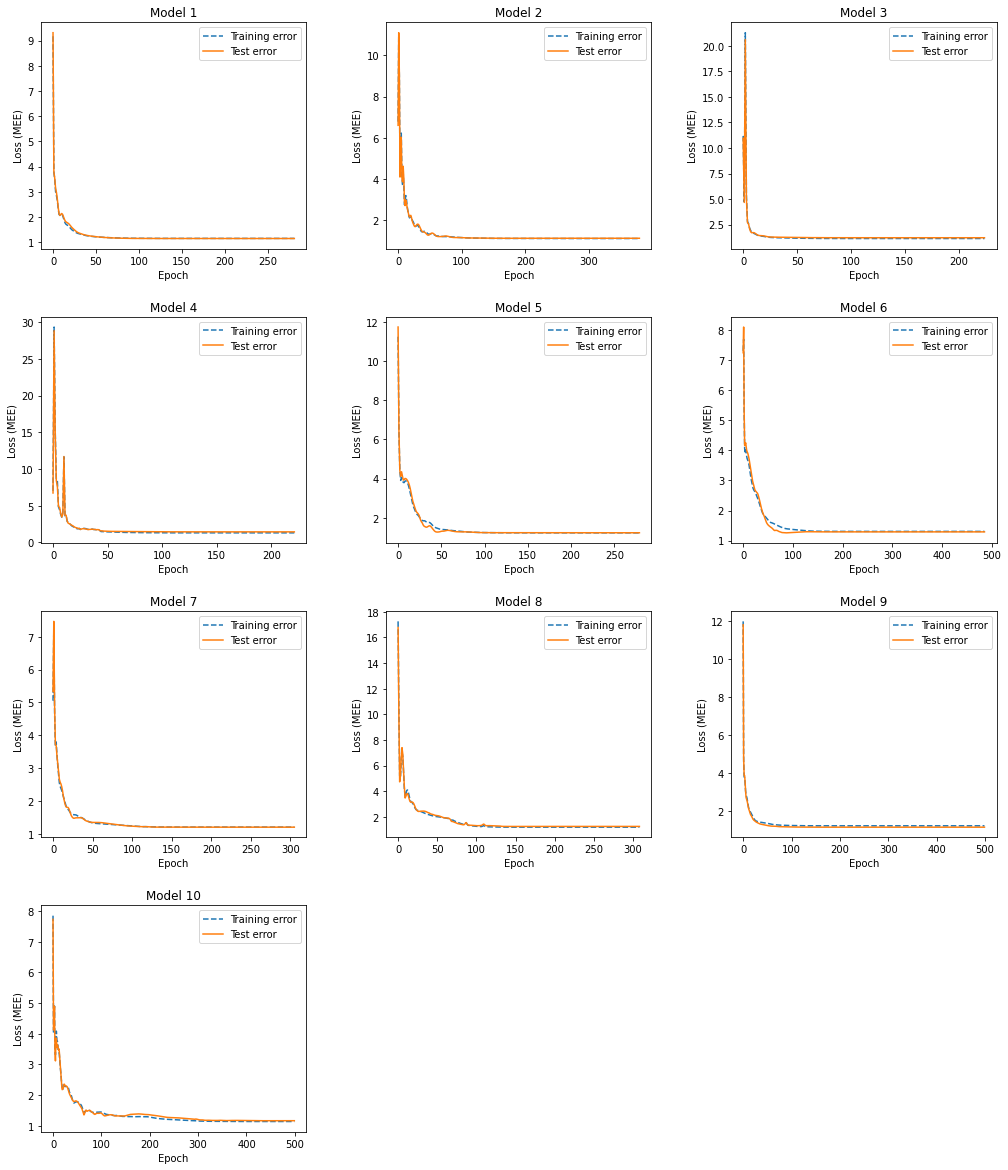

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(14,16))
axes = axes.flatten()
fig.tight_layout()

for i in range(len(eval_best_models)):
    epochs = epochs_best_models[i]
    loss_train = loss_train_best_models[i]
    loss_test = loss_test_best_models[i]
    plot_learning_curves(loss_train, loss_test, epochs, "Loss (MEE)", axes[i], i)

fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
fig.delaxes(axes[10])
fig.delaxes(axes[11])

In [30]:
y_pred_voting_ens_train_test = np.average(y_predictions_train, axis=0)
y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)
y_pred_voting_ens_blind_test = np.average(y_predictions_blind_test, axis=0)

print(f"MEE: {mee(y_test, y_pred_voting_ens_internal_test)}")

MEE: 1.0747868942723149


### Plot of coordinates x and y from the training set

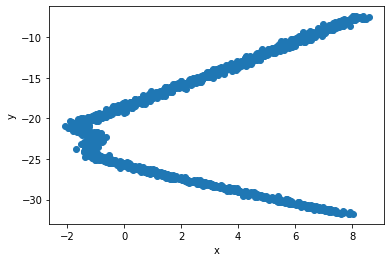

In [31]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(df_visual['x'], df_visual['y'])

In [32]:
def plot_coordinates(model, X, true_y = None):
    y_predicted = model.predict(X)
    y_predicted = pd.DataFrame(data=y_predicted, columns=["x", "y"])
    if not None:
        true_y = pd.DataFrame(data=true_y, columns=["x", "y"])
        plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4')


### Predicted points on internal test set

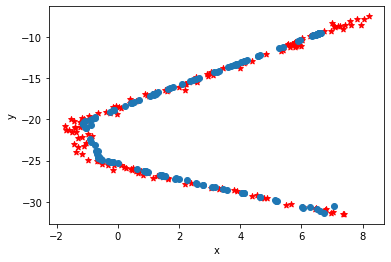

In [33]:
plot_coordinates(model, X_test, y_test)

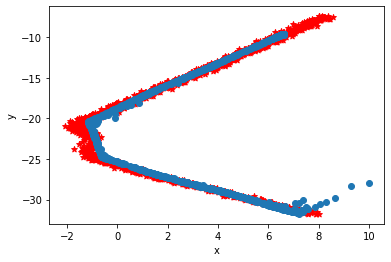

In [34]:
plot_coordinates(model, X_all, y_all)

### Predicted points on blind test set

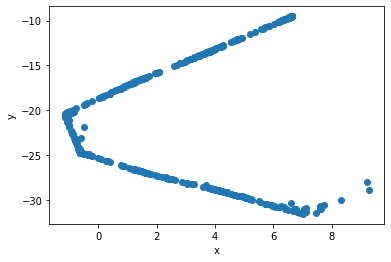

In [35]:
plot_coordinates(model, blind_ts)

## Ensemble 

First we try using the bagging method with 10 estimators.

In [36]:
bagging_ens = BaggingRegressor(model, n_estimators=10, n_jobs=-1, random_state=RS_NUMBER).fit(X, y)

In [37]:
y_predicted_ensemble = bagging_ens.predict(X_test)
print(f"Accuracy: {model.score(X_test, y_test)}")
print(f"MEE: {mee(y_test, y_predicted_ensemble)}")

Accuracy: 0.9395784067216093
MEE: 1.2460825023003446


Then we try the voting method using the 10 best models from the randomized search. 

In [38]:
y_predictions_internal_test = list()
y_predictions_blind_test = list()
epochs_best_models = list()

#fit every model
for model in best_models:
    model.fit(X,y)
    epochs_best_models.append(model.n_iter_)


#predictions on every model is averaged
for model in best_models:
    y_pred = model.predict(X_test)
    y_predictions_internal_test.append(y_pred)
    y_pred = model.predict(blind_ts)
    y_predictions_blind_test.append(y_pred)


/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [39]:
y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)
y_pred_voting_ens_blind_test = np.average(y_predictions_blind_test, axis=0)

print(f"MEE: {mee(y_internal_test, y_pred_voting_ens_internal_test)}")

NameError: name 'y_internal_test' is not defined

### Predicted points on internal test set using ensemble

#### BAGGING ENSEMBLE

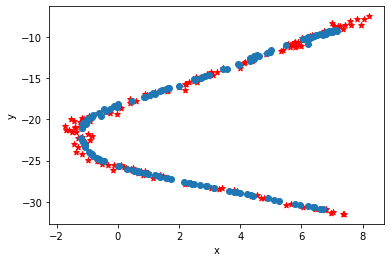

In [ ]:
#BAGGING ENSEMBLE
plot_coordinates(bagging_ens, X_test, y_test)

#### VOTING COMMITEE OF 10 BEST MODELS

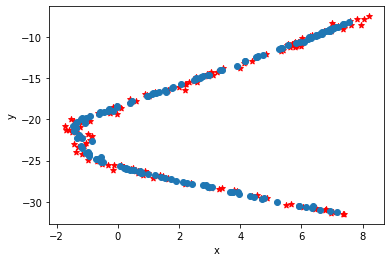

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_internal_test, columns=["x", "y"])
true_y = pd.DataFrame(data=y_internal_test, columns=["x", "y"])
plt.scatter(true_y['x'], true_y['y'], c='r', marker='*')
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

### Predicted points on blind test set using Ensemble

#### BAGGING ENSEMBLE

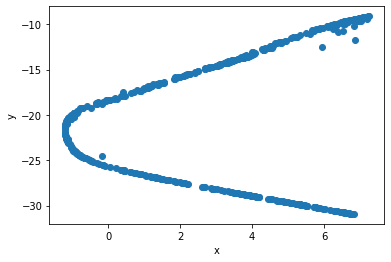

In [ ]:
#BAGGING ENSEMBLE
plot_coordinates(bagging_ens, blind_ts)

#### VOTING COMMITEE OF 10 BEST MODELS

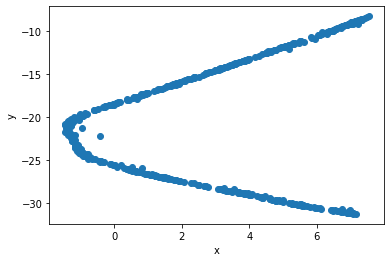

In [ ]:
y_predicted = pd.DataFrame(data=y_pred_voting_ens_blind_test, columns=["x", "y"])
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(y_predicted['x'], y_predicted['y'], c='#1f77b4');

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>